This notebook is an attempt to implement a Credit Card Fraud Detection model as presented by:

8.	Esenogho, E., Mienye, I. D., Swart, T. G., Aruleba, K., & Obaido, G. (2022). A Neural Network Ensemble with Feature Engineering for Improved Credit Card Fraud Detection. IEEE Access, 10, 16400–16407. https://doi.org/10.1109/access.2022.3148298

Dataset used:
https://www.kaggle.com/c/ieee-fraud-detection/data

Functions that define the various iteration of models:

In [1]:
import pandas as pd
import numpy as np

# Function to read dataset and return a dataframe.  Input the filename
def read_dataset(file_name):
    

    # Concatenate the file name with the path to the project data directory
    file_path = '.\\data\\' + file_name

    # Load csv into a dataframe
    df = pd.read_csv(file_path)
    
    # Return the dataframe
    return df

# Function to check for null data
def has_null_values(df):
    return df.isnull().values.any()

def count_unique_values(df):
    for column in df.columns:
        print(column, df[column].nunique())
    return

# Function to lable encode the categorical features of a dataframe.
# Input the list of columns to be encoded.
def label_encode_dataset(categorical_features, df):
    from sklearn.preprocessing import LabelEncoder

    # Create a LabelEncoder instance
    label_encoder = LabelEncoder()


    # Apply label encoding to each column in the DataFrame
    for column in categorical_features:
        df.loc[:, column] = label_encoder.fit_transform(df.loc[:, column])
    
    return df

# Function to split the dataset into a features only and targets only dataframes
# Input dataframe to split, list of feature column names and list of target column names.
def split_features_target(df, feature_cols, target_col):
    # X is the features only dataframe.  Includes all but last column
    X = df[feature_cols]
    # y is the target dataframe
    y = df[target_col]
    
    return X, y

# function to provide classifier metrics
# input true and predicted label sets
def calculate_classifier_metrics(true_labels, predicted_labels):
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    # Calculate model accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
    
    return precision, recall, f1, accuracy

def get_classifcation_report(true_labels, predicted_labels, name):
    from sklearn.metrics import classification_report
    from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    
    cm_report = classification_report(true_labels, predicted_labels)
    #print(cm_report)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    cm_display.ax_.set_title(name)
    plt.show()

    return cm_report

# function to provide regression metrics
# input true and predicted label sets
def calculate_regression_metrics(true_labels, predicted_labels):
    from sklearn.metrics import accuracy_score, mean_squared_error
    # Calculate mean squared error
    mse = mean_squared_error(true_labels, predicted_labels)
    
    return mse

def plot_roc(y_preds, model_names):
    # Generate predictions for each model (assuming y_test and y_pred_proba are available for each model)
    from sklearn.metrics import roc_curve, auc
    
    # Plot ROC curve for each model
    plt.figure(figsize=(8, 6))  # Set plot size
    for y_pred, model_name in zip(y_preds, model_names):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
      
    # Plot random classifier (diagonal line)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    
    # Set labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    
    # Show plot
    plt.show()

Feature Engineering of the data according to the primary paper.
1. Use just the train transaction data with 394 columns
2. Count the number of missing values for each column and determine the median missing values
3. Eliminate any column that is below the median.
4. Impute all missing values to the median value of the column

In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Read data file
df_trans = read_dataset('train_transaction.csv')

# Count the number of missing values
missing_values_count = df_trans.isna().sum(axis=0)
# Identify the median
median_missing_values = missing_values_count.median()
# Identify which values are less than or equal the median, which eliminates those below the median
columns_below_median = missing_values_count[missing_values_count <= median_missing_values]

# Target column list
target = ['isFraud']

# Feature column list
features = columns_below_median.index.tolist()
features.remove('isFraud')
features.remove('TransactionID')
# 
# Eliminate the columns not to be used.
df = df_trans[columns_below_median.index]

# Get the features
X = df.iloc[:, 2:]

# Get the target
y = df[target]

category_features = [col for col in X.columns if X[col].dtype not in ['float64', 'int64']]

# lable encode the category features
X = label_encode_dataset(category_features, X)  

# impute the missing values of each feature to the median value of that column
X = X.fillna(X.median())

# Scale the fetures
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Categorical features

Full input dataset

In [3]:
df_trans

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Features after dimensionatlity reduction

In [4]:
df.iloc[:, 2:]

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000
1,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,135.0,0.000000,0.000000,0.000000,50.0,1404.0,790.0,0.000000,0.000000,0.000000
4,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,...,0.0,47.950001,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000
590536,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
590537,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
590538,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,...,117.0,317.500000,669.500000,317.500000,0.0,2234.0,0.0,0.000000,0.000000,0.000000


data after dimensionality reduction, Null values set to feature's mean, and scaling.

In [5]:
X

array([[0.00000000e+00, 2.13697908e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.35940926e-08, 9.00174530e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.38799239e-06, 1.83951976e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.99996693e-01, 9.61231970e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99997265e-01, 3.65558719e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 8.75779735e-03, 1.00000000e+00, ...,
        2.69027496e-03, 2.69027496e-03, 2.69027496e-03]])

In [6]:
X.shape

(590540, 199)

Feature Engineering is complete and ready for training/test split

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Flatten to address data type error coming from model
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

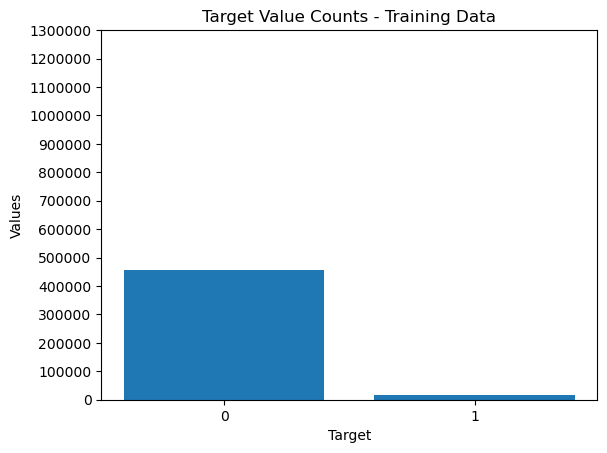

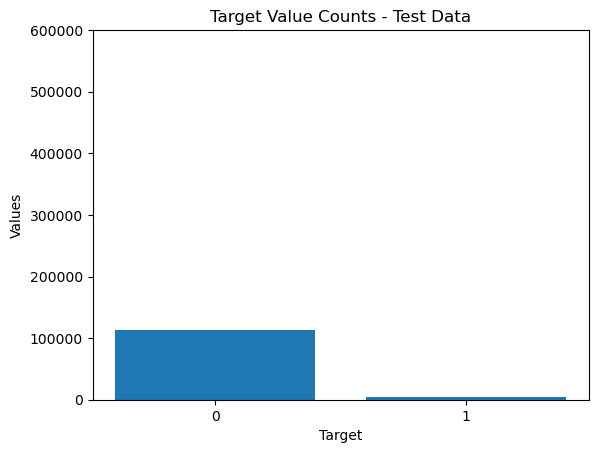

In [8]:
import matplotlib.pyplot as plt

fraud_values, fraud_counts = np.unique(y_train, return_counts=True)
count_dict = dict(zip(fraud_values, fraud_counts))
count_series = pd.Series(count_dict)


# Creating the bar plot
plt.bar(count_series.index, count_series.values)
plt.xticks(count_series.index, ['0', '1'])
plt.yticks(range(0, 1300001, 100000), [str(i) for i in range(0, 1300001, 100000)])
plt.title('Target Value Counts - Training Data')
plt.xlabel('Target')
plt.ylabel('Values')

# Displaying the plot
plt.show()

fraud_values_test, fraud_counts_test = np.unique(y_test, return_counts=True)
count_test_dict = dict(zip(fraud_values_test, fraud_counts_test))
count_series_test = pd.Series(count_test_dict)  

plt.bar(count_series_test.index, count_series_test.values)
plt.xticks(count_series_test.index, ['0','1'])
plt.yticks(range(0, 600001, 100000), [str(i) for i in range(0, 600001, 100000)])
plt.title('Target Value Counts - Test Data')
plt.xlabel('Target')
plt.ylabel('Values')

# Displaying the plot
plt.show()

First iteration of models:  Primary paper's Enhanced Recall Ensemble model using imbalanced data

In [9]:
from imblearn.over_sampling import SMOTE

# SMOTE Oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Now that both classes have been equalized, scale down the dataset to prevent overfitting
subset_size = 500000  # Specify the desired size of the subset
indices = np.random.choice(X_smote.shape[0], size=subset_size, replace=False)
X_smote = X_smote[indices]
y_smote = y_smote[indices]

print("After the Application of SMOTE Oversampling of the Minority Class:")
print("Number of Rows Features:", len(X_smote))
print("Number of Rows Fraud:",(y_smote == 1).sum())
print("Number of Rows Not Fraud:", (y_smote == 0).sum())


After the Application of SMOTE Oversampling of the Minority Class:
Number of Rows Features: 500000
Number of Rows Fraud: 250206
Number of Rows Not Fraud: 249794


In [20]:
X_test.shape

(118108, 199)

In [15]:
y_smote.shape

(500000,)

In [39]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense
import os

def sort_data_by_datetime(X, y):
    sorted_indices = np.argsort(X[:, 0])
    return X[sorted_indices], y[sorted_indices]

# Sort data by DateTime
x_smote_sorted, y_smote_sorted = sort_data_by_datetime(X_smote, y_smote)
x_test_sorted, y_test_sorted = sort_data_by_datetime(X_test, y_test)

# Apply PCA
pca = PCA(n_components=50)  # Retain 50 components
X_train_pca = pca.fit_transform(x_smote_sorted)
X_test_pca = pca.transform(x_test_sorted)

# Use GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set the GPU device index (0 for the first GPU)

model_lstm = Sequential()
model_lstm.add(LSTM(units=64, input_shape=(X_train_pca.shape[1], 1)))
model_lstm.add(Dense(units=1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.fit(X_train_pca, y_smote_sorted, epochs=10, batch_size=32)

# Initialize AdaBoost with decision stumps
model_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50)
model_adaboost.fit(X_train_pca, y_smote_sorted)

# Evaluate both models on the testing data
lstm_accuracy = model_lstm.evaluate(X_test_pca, y_test_sorted)[1]
adaboost_accuracy = model_adaboost.score(X_test_pca, y_test_sorted)

print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
print(f"AdaBoost Accuracy: {adaboost_accuracy:.4f}")

Epoch 1/10


C:\Users\cpiac\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15625/15625 ━━━━━━━━━━━━━━━━━━━━ 182s 11ms/step - accuracy: 0.6309 - loss: 0.6308
Epoch 2/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 195s 12ms/step - accuracy: 0.7088 - loss: 0.5575
Epoch 3/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 183s 12ms/step - accuracy: 0.7422 - loss: 0.5180
Epoch 4/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 190s 12ms/step - accuracy: 0.7678 - loss: 0.4855
Epoch 5/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 191s 11ms/step - accuracy: 0.7811 - loss: 0.4656
Epoch 6/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 189s 12ms/step - accuracy: 0.7937 - loss: 0.4450
Epoch 7/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 196s 12ms/step - accuracy: 0.8043 - loss: 0.4277
Epoch 8/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 208s 12ms/step - accuracy: 0.8153 - loss: 0.4072
Epoch 9/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 180s 12ms/step - accuracy: 0.8231 - loss: 0.3911
Epoch 10/10
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 199s 13ms/step - accuracy: 0.8337 - loss: 0.3733


C:\Users\cpiac\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


3691/3691 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8506 - loss: 0.3475
LSTM Accuracy: 0.8302
AdaBoost Accuracy: 0.7358


In [45]:
np.unique(y_test_sorted)

array([0, 1], dtype=int64)

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions from LSTM model
p_lstm = model_lstm.predict(X_test_pca)

threshold = 0.5
predicted_classes = (p_lstm > threshold).astype(int)

# Predictions from AdaBoost model
p_adaboost = model_adaboost.predict(X_test_pca)

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test_sorted, predicted_classes)
accuracy_adaboost = accuracy_score(y_test_sorted, p_adaboost)

# Calculate precision
precision_lstm = precision_score(y_test, predicted_classes)
precision_adaboost = precision_score(y_test_sorted, p_adaboost)

# Calculate recall
recall_lstm = recall_score(y_test, predicted_classes)
recall_adaboost = recall_score(y_test_sorted, p_adaboost)

# Calculate F1-score
f1_score_lstm = f1_score(y_test, predicted_classes)
f1_score_adaboost = f1_score(y_test_sorted, p_adaboost)

# Calculate confusion matrix
confusion_matrix_lstm = confusion_matrix(y_test_sorted, predicted_classes)
confusion_matrix_adaboost = confusion_matrix(y_test_sorted, p_adaboost)

# Print the metrics
print("LSTM Model:")
print("Accuracy:", accuracy_lstm)
print("Precision:", precision_lstm)
print("Recall:", recall_lstm)
print("F1-score:", f1_score_lstm)
print("Confusion Matrix:\n", confusion_matrix_lstm)

print("\nAdaBoost Model:")
print("Accuracy:", accuracy_adaboost)
print("Precision:", precision_adaboost)
print("Recall:", recall_adaboost)
print("F1-score:", f1_score_adaboost)
print("Confusion Matrix:\n", confusion_matrix_adaboost)

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step
LSTM Model:
Accuracy: 0.8302401192129237
Precision: 0.03640644810722695
Recall: 0.18953323903818953
F1-score: 0.0610803008432728
Confusion Matrix:
 [[94920 18946]
 [ 1104  3138]]

AdaBoost Model:
Accuracy: 0.7357587970332238
Precision: 0.09184198577266535
Recall: 0.7152286657237152
F1-score: 0.16278133970008316
Confusion Matrix:
 [[83865 30001]
 [ 1208  3034]]
